# Opera Package

### Cargamos las librerías y los datos

In [67]:
library(ggplot2)
library(zoo)
library(forecast)
library(tseries)
library(FitARMA)

library(opera)

Warning message:
"package 'opera' was built under R version 3.3.3"

In [68]:
accidentes <- as.ts(dmseries('http://data.is/1yFXOBi'))

acc.train <- window(accidentes, start = c(1960,1), end = c(1973,12))
acc.test <- window(accidentes, start = c(1974,1))

In [69]:
# Función genérica para plotting de test vs pred a través de ggplot2
combine <- function(test, pred) {
  require(ggplot2)
  p <- ggplot() +
    geom_line(aes(x = index(as.zoo(test)), y = coredata(as.zoo(test)), colour = 'Test')) +
    geom_line(aes(x = index(as.zoo(test)), y = pred, colour = 'Prediccion')) +
    scale_color_manual(name = 'Leyenda', values = c('Test' = 'black', 'Prediccion' = 'red'),
                       labels = c('Test','Prediccion'))
  p
}

<br>

### Calculamos los distintos modelos a combinar

In [70]:
# Red neuronal
red <- nnetar(acc.train, repeats = 25, size = 20, decay = 9.5, p = 20, P = 4)
pred.red <- forecast(red, h = 12)
accuracy(pred.red, acc.test) # 13.2...

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.006635606,19.34069,15.18869,-2.899753,11.53002,0.8563193,0.1842157,NA
Test set,-5.993339574,14.84124,13.28391,-5.762140,10.16195,0.7489300,-0.4262237,0.4427104


In [71]:
# SARIMA(1,0,0)(1,0,0)12
sarima <- auto.arima(acc.train, test = 'adf')
pred.sarima <- forecast(sarima, h = 12)
accuracy(pred.sarima, acc.test) # 14.86938

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.481911,20.89727,16.32299,-2.080903,13.43304,0.9202698,-0.0813211,NA
Test set,-8.013324,18.19253,14.86938,-8.041157,12.04800,0.8383172,-0.2694620,0.4505771


In [72]:
# Damped HoltWinters Mutiplicativo
pred.hw <- hw(acc.train, h = 12, damped = TRUE, seasonal = 'multiplicative',
            initial = 'optimal')
accuracy(pred.hw, acc.test) # 15.04762

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.113903,16.03383,12.68223,-0.4267724,9.854084,0.7150085,0.08131717,NA
Test set,-13.063209,20.12153,15.04762,-10.5419375,11.866680,0.8483659,-0.33286407,0.5553684


Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


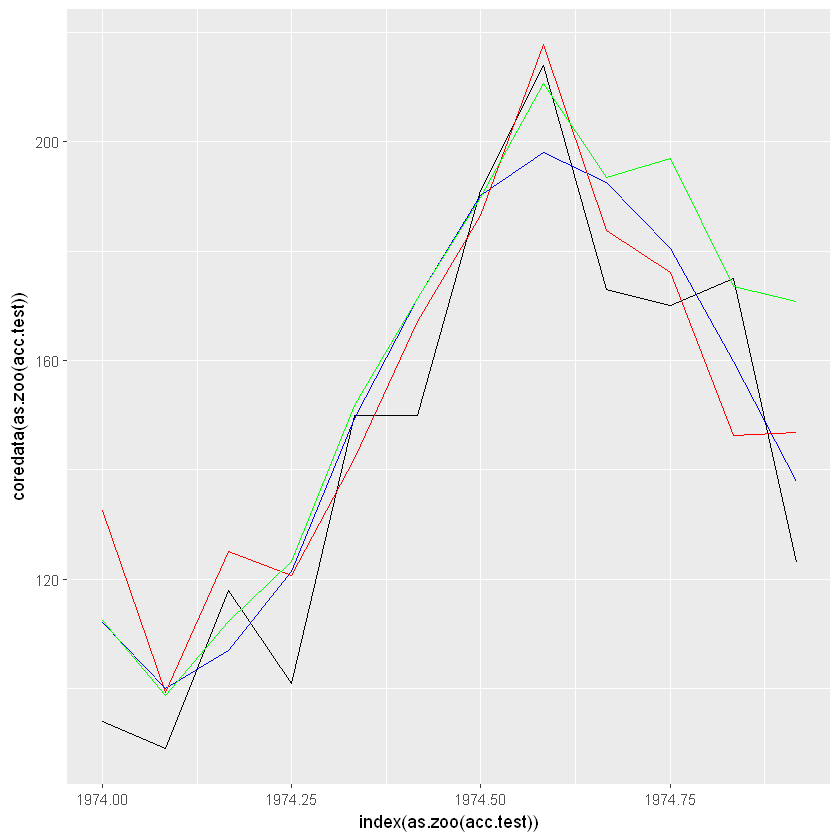

In [73]:
# Juntamos las predicciones
X <- cbind(red = pred.red$mean, sarima = pred.sarima$mean, hw = pred.hw$mean)
p <- ggplot() +
  geom_line(aes(x = index(as.zoo(acc.test)), y = coredata(as.zoo(acc.test)))) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 1]), col = 'blue') +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 2]), col = 'red') +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 3]), col = 'green')
p

<br>

### MAE por observación

In [74]:
# Loss
loss(X, as.vector(acc.test), loss.type = 'absolute')

red,sarima,hw
18.0494869,38.527985,18.450649
10.9852020,10.320400,9.710105
11.0707441,7.150485,5.664850
20.4873395,19.718444,22.231049
0.5967131,7.863369,1.744073
21.3087812,17.094233,21.410794
0.7906701,4.476612,1.277397
16.0572318,3.778124,3.435301
19.4464734,10.727018,20.507963
10.5449507,6.081625,26.904985


<br>

### Combinaciones fuera de línea

Warning message in bestConvex(Y, experts, awake = awake, loss.type = loss.type, :
"The best convex oracle is only approximated (using optim)."

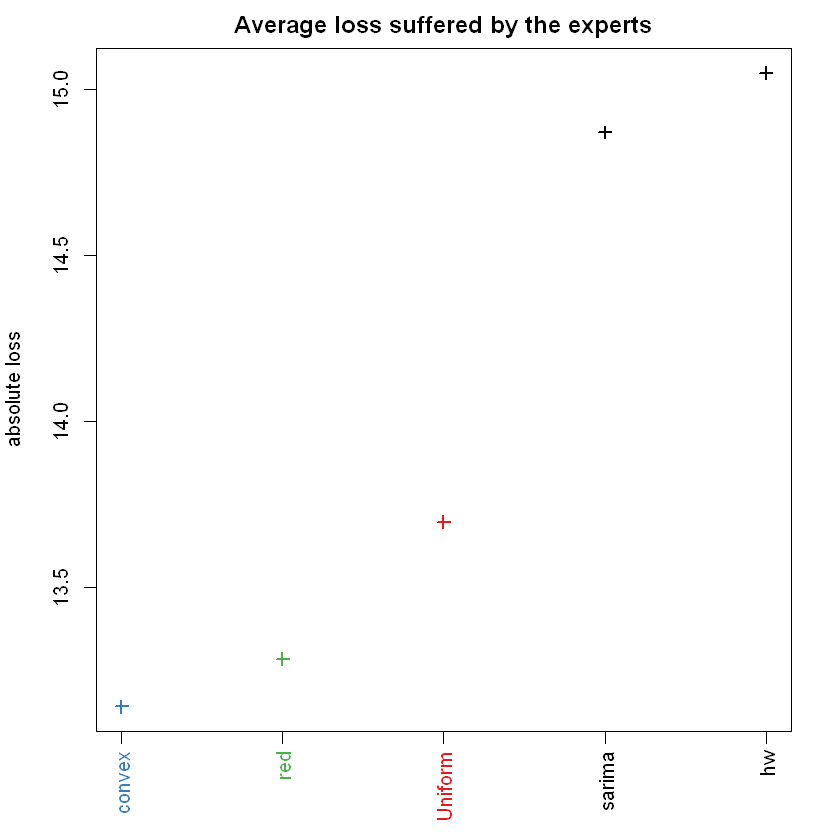

In [75]:
oracle.convex <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "convex") # convex
plot(oracle.convex)

In [76]:
print(oracle.convex)

Call:
oracle.default(Y = acc.test, experts = X, model = "convex", loss.type = "absolute")

Coefficients:
   red sarima       hw
 0.393  0.607 5.08e-21

                      rmse  mape
Best expert oracle:   14.8 0.102
Uniform combination:  16.2 0.109
Best convex oracle:   16.0 0.105


In [77]:
accuracy(as.vector(oracle.convex$prediction), acc.test) # 13.1...

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-7.220476,15.99627,13.14056,-7.146638,10.51543,-0.34122,0.4137707


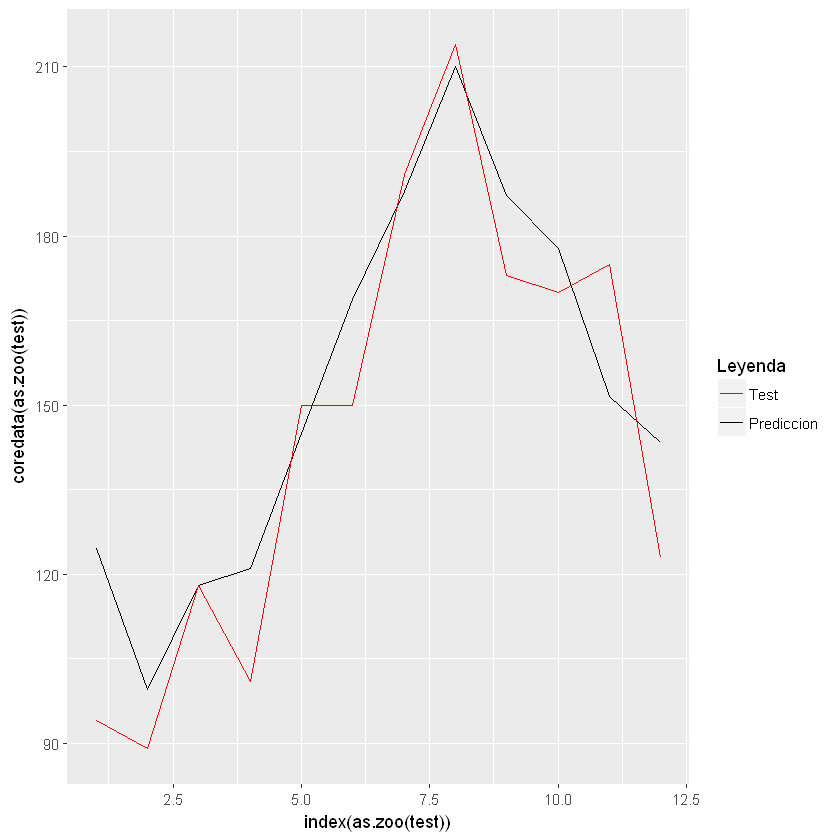

In [78]:
combine(as.vector(oracle.convex$prediction), acc.test)

Warning message in bestLinear(Y, experts, lambda = lambda, loss.type = loss.type):
"The best linear oracle is only approximated (using optim)."

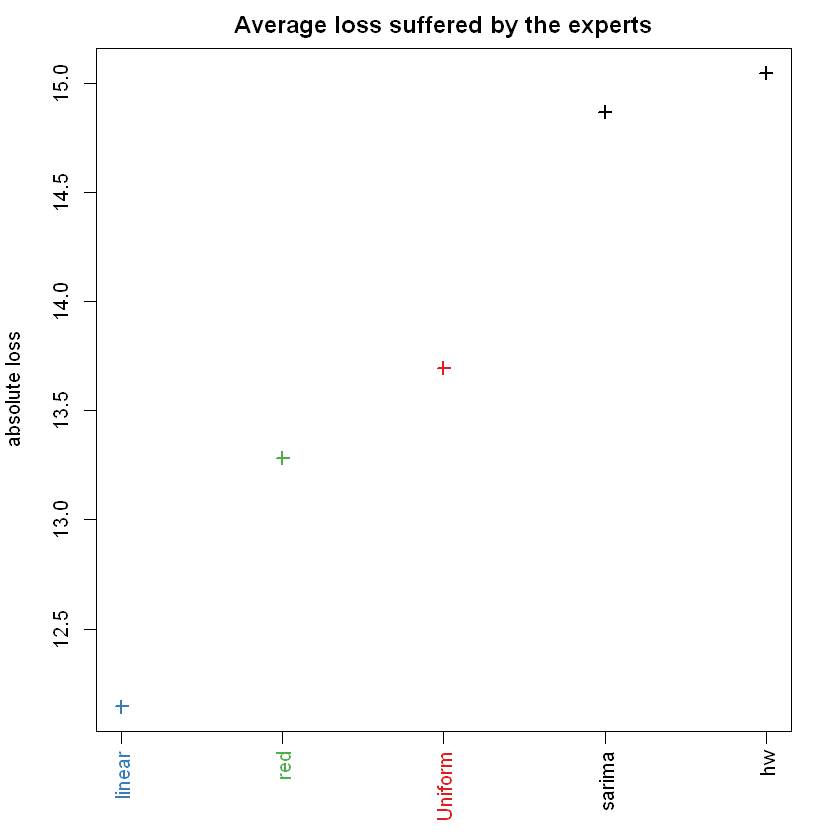

In [79]:
oracle.linear <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "linear")
plot(oracle.linear)

In [80]:
print(oracle.linear)

Call:
oracle.default(Y = acc.test, experts = X, model = "linear", loss.type = "absolute")

Coefficients:
   red sarima    hw
 0.967 -0.367 0.305

                      rmse   mape
Best expert oracle:   14.8 0.1020
Uniform combination:  16.2 0.1090
Best linear oracle:   16.5 0.0786


In [81]:
accuracy(as.vector(oracle.linear$prediction), acc.test) # 12.2...

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.015066,16.54989,12.14412,3.67478,7.857641,-0.3613892,0.5591665


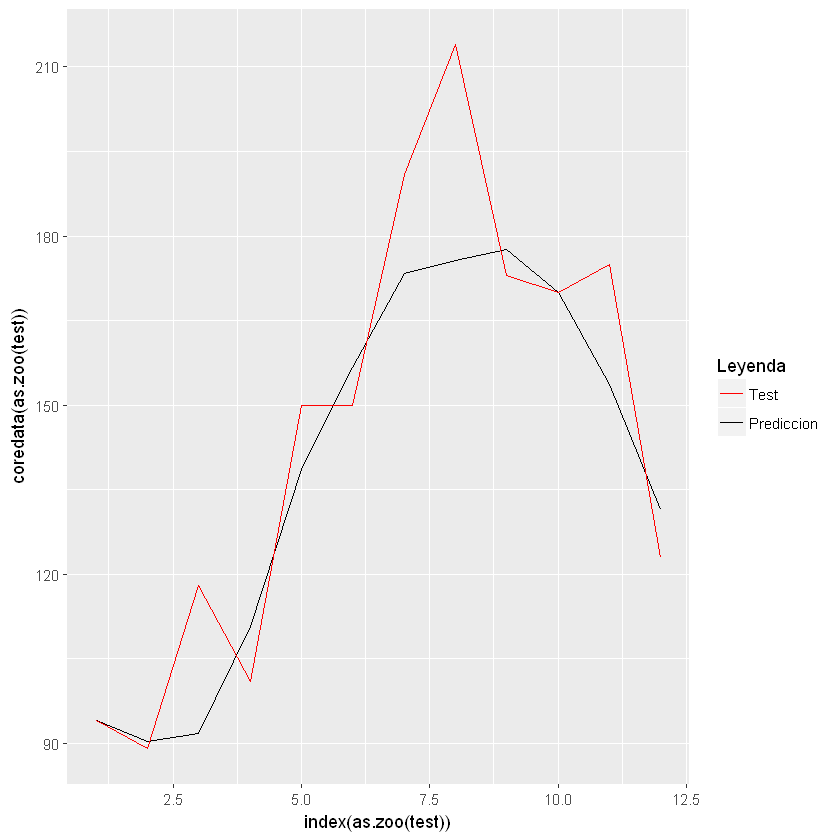

In [82]:
combine(as.vector(oracle.linear$prediction), acc.test) # Comprobar siempre figuras

<br>

### Combinaciones en línea

In [83]:
mix <- mixture(model = 'EWA', loss.type = 'absolute', coefficients = 'Uniform')
model <- mix

for (i in 1:length(as.vector(acc.test))) {
  model <- predict(model, X[i,], as.vector(acc.test)[i])
}

print(model)

Aggregation rule: EWA 
Loss function:  absolute loss 
Gradient trick:  TRUE 
Coefficients: 
 red   sarima       hw
   1 1.43e-05 4.61e-11


In [84]:
model$weights

red,sarima,hw
0.3333333,3.333333e-01,0.3333333
0.5989667,7.650749e-10,0.4010333
0.4546589,3.820000e-02,0.5071411
0.3248312,3.168483e-01,0.3583205
0.3325251,3.319907e-01,0.3354842
0.3333659,3.327081e-01,0.3339260
0.3333235,3.332841e-01,0.3333924
0.3333339,3.333243e-01,0.3333419
0.3333317,3.333336e-01,0.3333347
0.3333331,3.333335e-01,0.3333334


In [85]:
accuracy(as.vector(model$prediction), acc.test) # 14.08114

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-8.670873,16.38221,14.08105,-7.819935,11.18961,-0.4796762,0.4518587


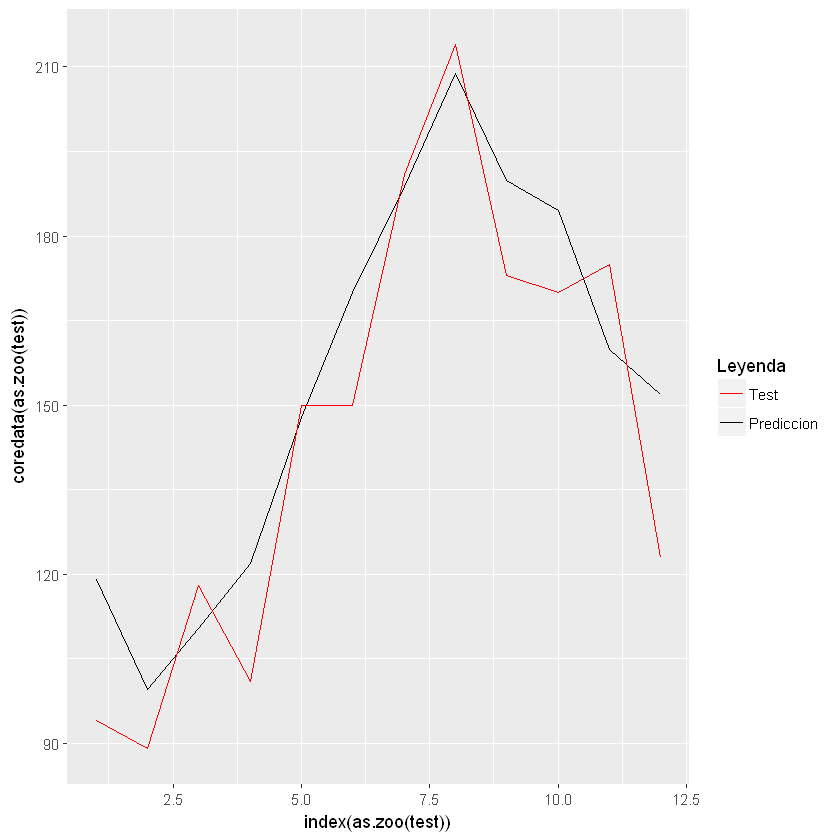

In [86]:
combine(as.vector(model$prediction), acc.test)

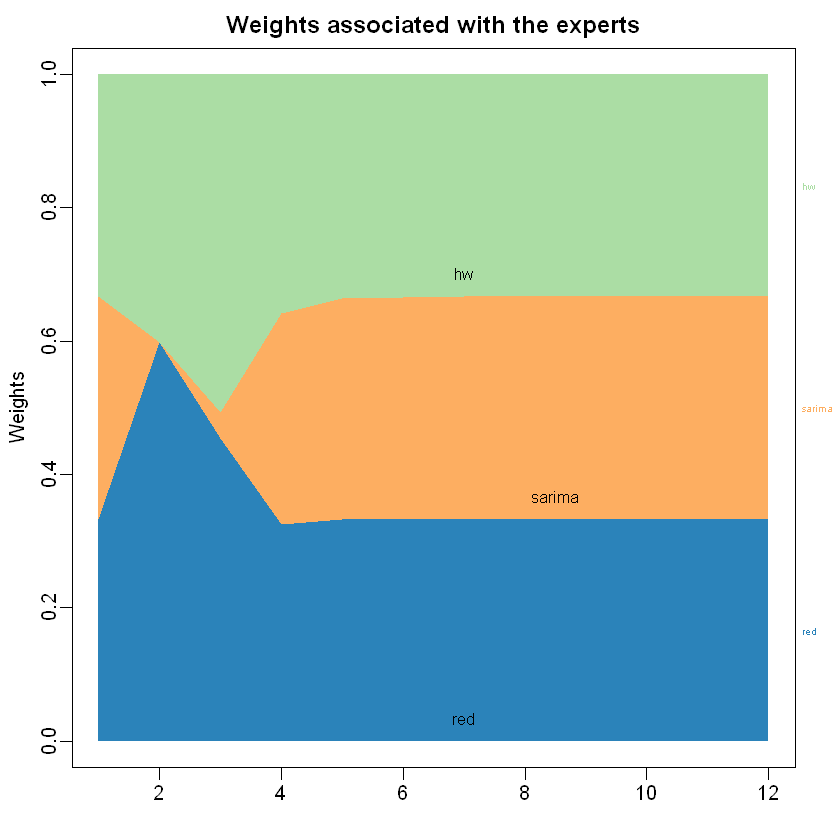

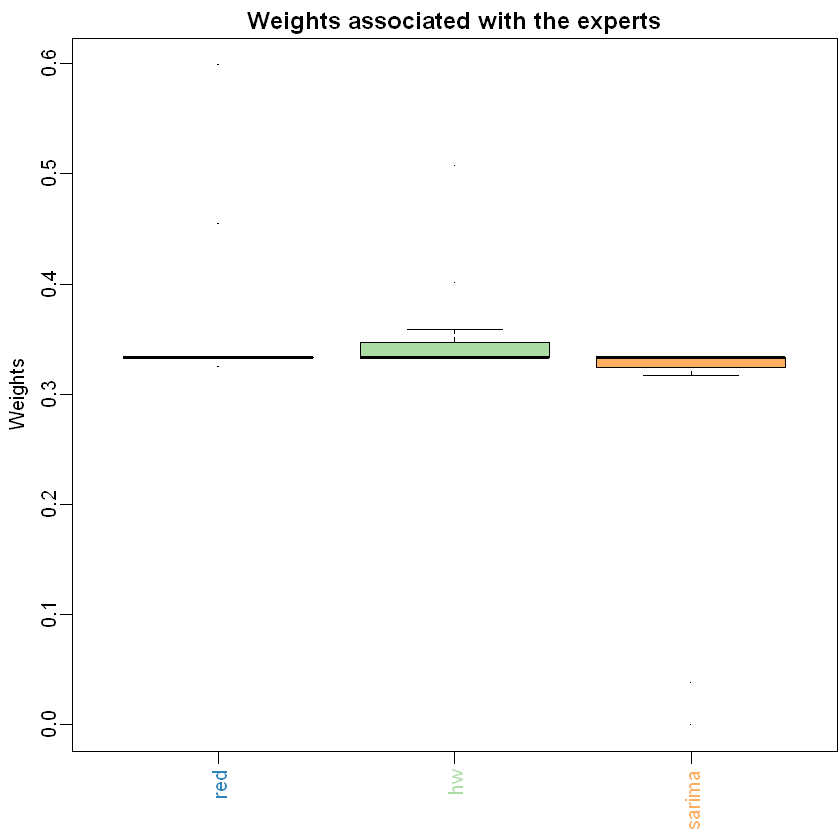

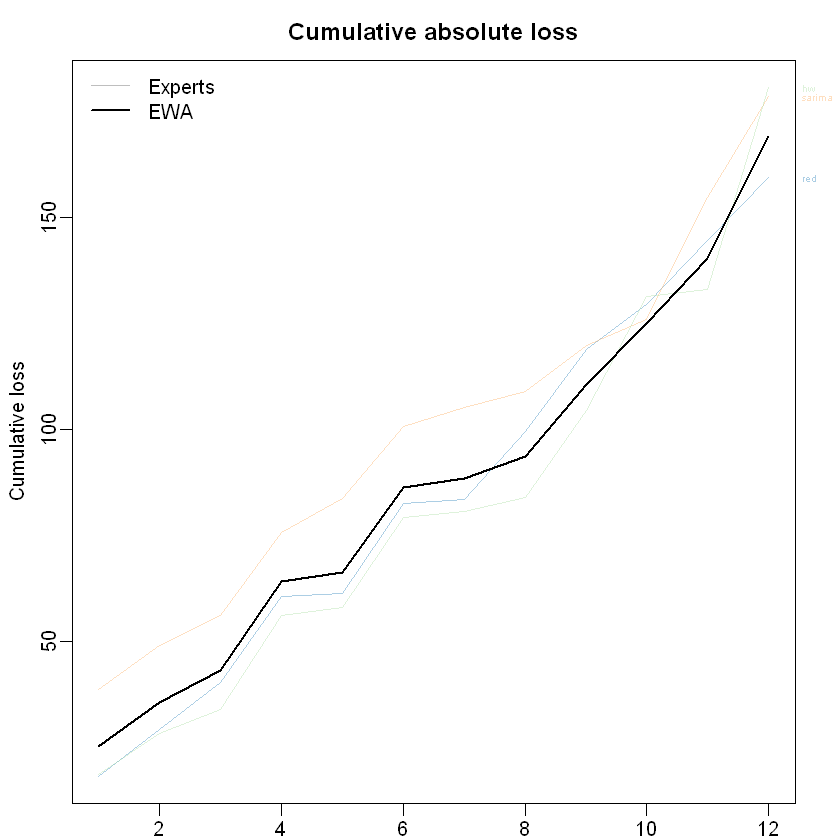

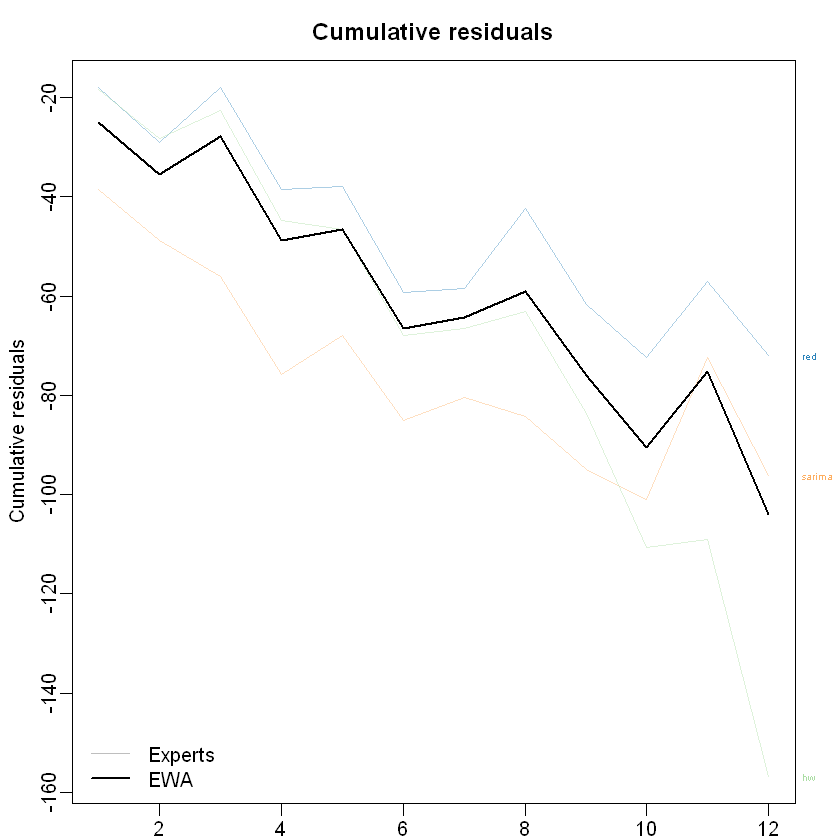

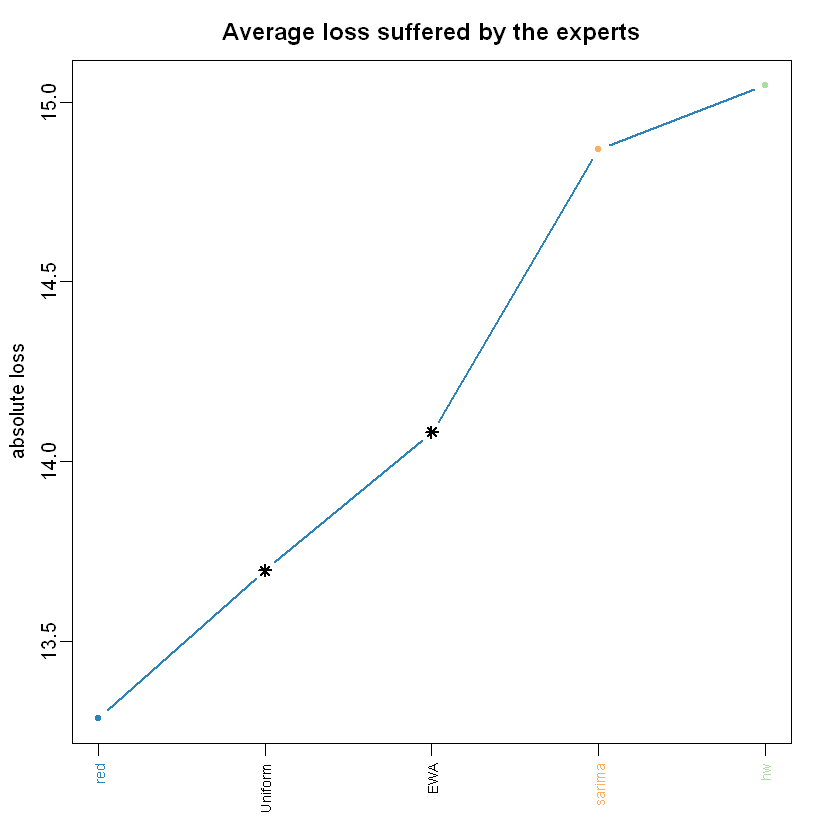

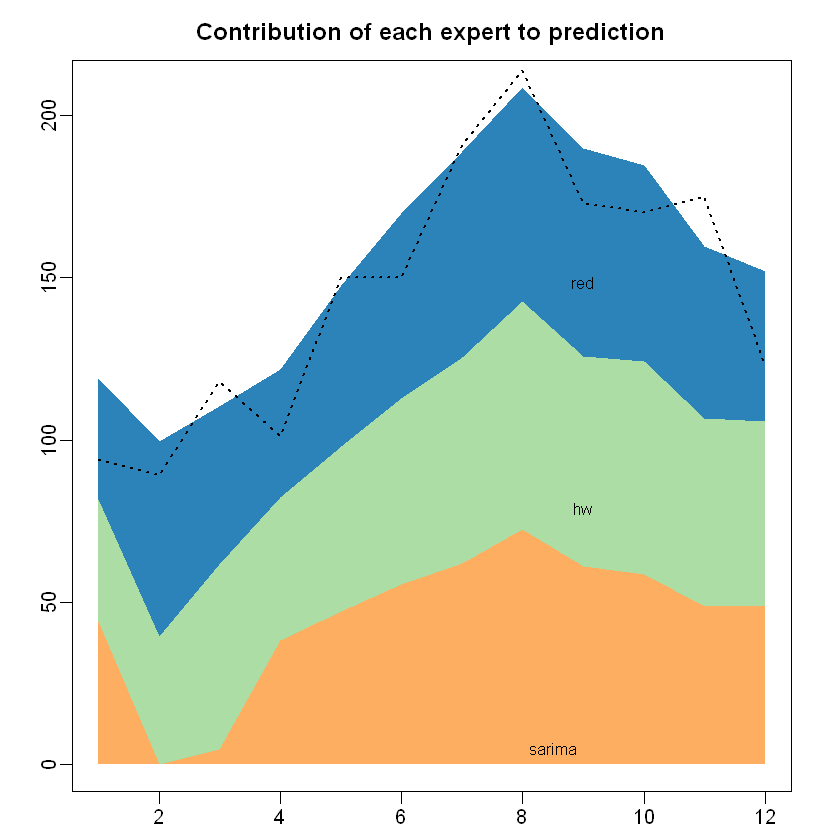

In [88]:
plot(model, pause = TRUE)